# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. _Make sure to answer every question marked with a `Q:` for full credit._


In [31]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

In [32]:
# add any additional libaries you need here
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
# This function comes from the BTAP repo.
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1]  # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(
                "  %s (%2.2f)"
                % (features[largest[i]], abs(words[largest[i]] * 100.0 / total))
            )

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.


In [34]:
# categories of articles in Brown corpus
for category in brown.categories():
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.


In [35]:
categories = ["editorial", "government", "news", "romance", "hobbies"]

category_list = []
file_ids = []
texts = []

for category in categories:
    for file_id in brown.fileids(categories=category):

        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)

        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))


df = pd.DataFrame()
df["category"] = category_list
df["id"] = file_ids
df["text"] = texts

df.shape

(166, 3)

In [36]:
# Let's add some helpful columns on the df
df["char_len"] = df["text"].apply(len)
df["word_len"] = df["text"].apply(lambda x: len(x.split()))

<Axes: xlabel='category'>

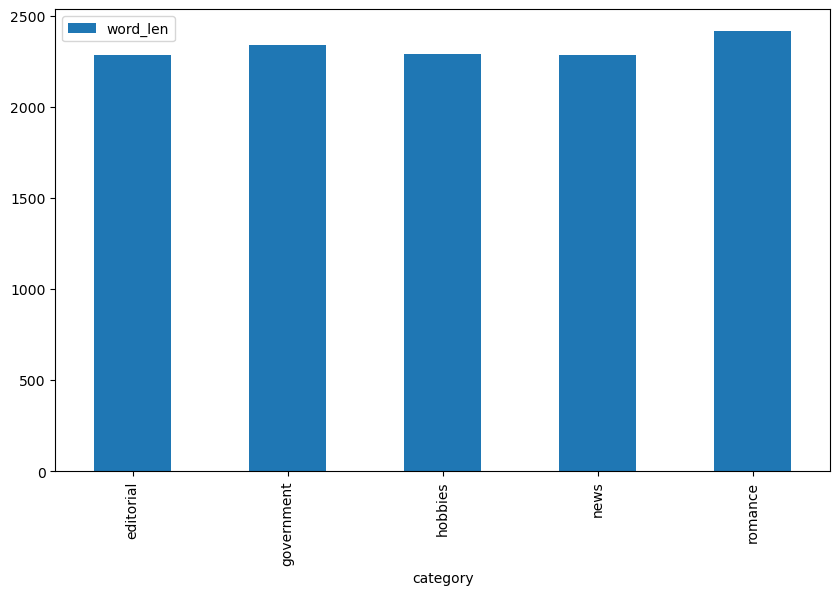

In [37]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.


In [38]:
count_text_vectorizer = CountVectorizer(
    stop_words=list(stopwords), min_df=5, max_df=0.7
)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/home/junc/miniconda3/envs/ads509/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [39]:
tfidf_text_vectorizer = TfidfVectorizer(
    stop_words=list(stopwords), min_df=5, max_df=0.7
)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df["text"])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold?

A: Both dataframes are document-term matrices which is a vector representation
of all the documents. The `count_text_vectorizer` is a bag-of-words matrix
where each column is a unique word in the corpus and each row represents a
document and each cell is the raw count of how many times the word appears in
that document.
The `tfidf_text_vectorizer` is similar to the `count_text_vectorizer` except
instead of raw counts, the cells are filled with the weights of the words
based on Term Frequency - Inverse Document Frequency.


## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections.


In [40]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [41]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results.


In [42]:
# Your code here
# ChatGPT was used to help understand the best way to do this comparison
# use argmax to find dominant topic in W_text_matrix and assign it to
# column "topic" in dataframe df
df["topic"] = np.argmax(W_text_matrix, axis=1)
# create contingency table to compare NMF topics to Brown categories
topic_category = pd.crosstab(df["topic"], df["category"])
# normalize results
topic_category_norm = topic_category.div(topic_category.sum(axis=1), axis=0)

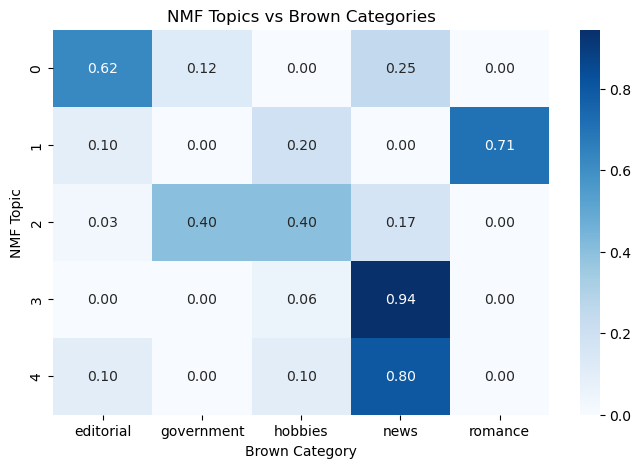

In [43]:
%matplotlib inline

# create heatmap using normalized contingency table
plt.figure(figsize=(8, 5))
sns.heatmap(topic_category_norm, annot=True, cmap="Blues", fmt=".2f")
plt.title("NMF Topics vs Brown Categories")
plt.xlabel("Brown Category")
plt.ylabel("NMF Topic")
plt.show()

Q: How does your five-topic NMF model compare to the original Brown categories?

A: Based on the heatmap, the NMF Topics 3 and 4 corresponded to articles that were labeled as "news". The top 3 words for topic 3 are "mrs", "mr", and "said. The top 3 words for topic 4 are "game", "league", and "ball". I believe this is a reasonable categorization as these documents could easily be about sports but not about romance or an editorial. Topic 0, which include "mr", "president", and "kennedy" was classified as "editorial" in the Brown corpus. These documents are probably newspaper articles writing about the President. 


## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above.

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results.


In [ ]:
# Your code here

Q: How does your five-topic LSA model compare to the original Brown categories?

A: <!-- Your answer here -->


In [ ]:
# call display_topics on your model

Q: What is your interpretation of the display topics output?

A:


## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization.


In [ ]:
# Fit your LDA model here

In [ ]:
# Call `display_topics` on your fitted model here

Q: What inference do you draw from the displayed topics for your LDA model?

A: <!-- Your answer here -->

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

A: <!-- Your answer here -->


In [ ]:
lda_display = pyLDAvis.lda_model.prepare(
    lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False
)

In [ ]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: <!-- Your answer here -->
